In [ ]:
import numpy as np

In [ ]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [ ]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [ ]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)


(70000,)

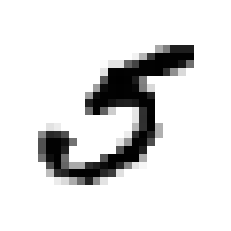

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest')
plt.axis('off')
plt.show()

In [ ]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

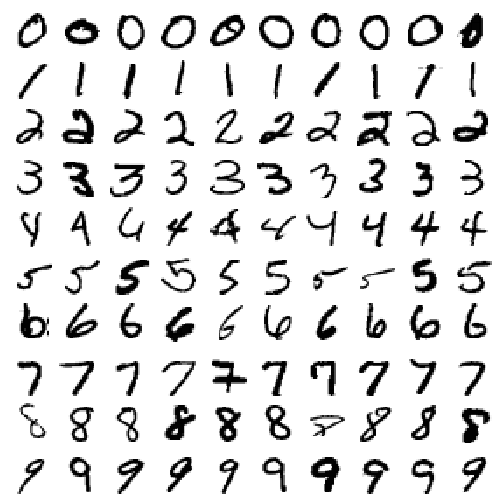

In [ ]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]


In [ ]:
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#Binary Classifier

In [ ]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier #StochasticGradientDescent

sgd_clf = SGDClassifier(loss='hinge', max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [ ]:
sgd_clf.predict([some_digit])

array([ True])

Measuring Accuracy

In [ ]:
from sklearn.model_selection import cross_val_score

cross_val_score(estimator = sgd_clf, X=X_train, y=y_train_5, cv=3, scoring="accuracy")

array([0.9541 , 0.9542 , 0.96405])

In [ ]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90905, 0.91115, 0.90875])

Confusion Matrix, Precision/Recall

In [ ]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred_5 = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred_5)

array([[53058,  1521],
       [ 1032,  4389]])

In [ ]:
from sklearn import metrics

print(metrics.classification_report(y_train_5, y_train_pred_5))

              precision    recall  f1-score   support

       False       0.98      0.97      0.98     54579
        True       0.74      0.81      0.77      5421

    accuracy                           0.96     60000
   macro avg       0.86      0.89      0.88     60000
weighted avg       0.96      0.96      0.96     60000



In [ ]:
y_scores_some_digit = sgd_clf.decision_function([some_digit])
y_scores_some_digit

array([23049.31717888])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
method="decision_function")
y_scores.shape

(60000,)

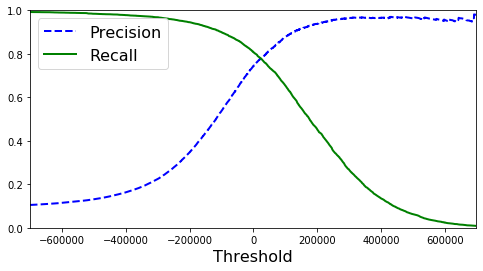

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
plt.show()

In [ ]:
(y_train_pred_5 == (y_scores > 0)).all()

True

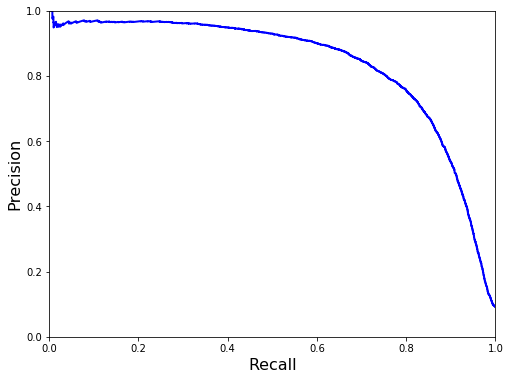

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [ ]:
y_train_pred_90 = (y_scores > 70000) #decide to aim for 90% precision
y_train_pred_90.shape

array([False, False, False, ..., False, False, False])

In [ ]:
print(metrics.classification_report(y_train_5, y_train_pred_90))

              precision    recall  f1-score   support

       False       0.97      0.99      0.98     54579
        True       0.84      0.71      0.77      5421

    accuracy                           0.96     60000
   macro avg       0.91      0.85      0.87     60000
weighted avg       0.96      0.96      0.96     60000



In [ ]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.8404881237742428, 0.7114923445858697)

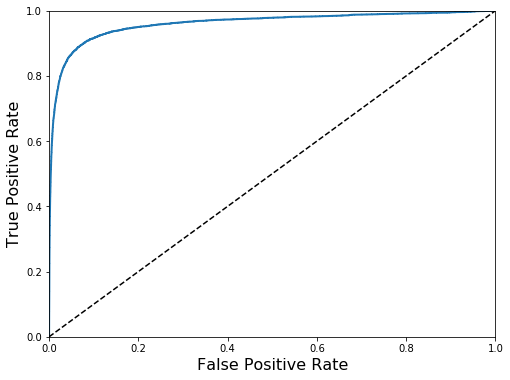

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.960280212887054

*TIP
* Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder how to decide which one to use. As a
rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false
positives than the false negatives, and the ROC curve otherwise. For example, looking at the previous ROC curve (and the ROC
AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to
the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be
closer to the top-right corner).

RandomForest vs SDG(SVM) on ROC, AUC

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

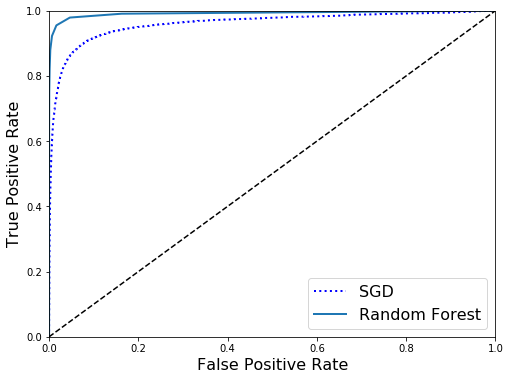

In [ ]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
print(metrics.classification_report(y_train_5, y_train_pred_forest))
roc_auc_score(y_train_5, y_scores_forest)

              precision    recall  f1-score   support

       False       0.98      1.00      0.99     54579
        True       0.98      0.82      0.90      5421

    accuracy                           0.98     60000
   macro avg       0.98      0.91      0.94     60000
weighted avg       0.98      0.98      0.98     60000



0.9917492809806123

# Multiclass Classification

In [ ]:
from sklearn.linear_model import SGDClassifier #StochasticGradientDescent

sgd_clf = SGDClassifier(loss='hinge', max_iter=5, tol=-np.infty, random_state=42)

sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit]) # ??

array([5], dtype=int8)

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-134924.80545864, -366968.6969944 , -446213.46093822,
        -325344.29534435, -459723.67827364,  119545.13651902,
        -680010.92319649, -268097.89330708, -628403.56817242,
        -587717.47161541]])

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
print(ovo_clf.predict([some_digit]))

[5]


In [ ]:
len(ovo_clf.estimators_) # 10개 class one to one = 10*9/2

45

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [ ]:
forest_clf.predict_proba([some_digit])

array([[0. , 0. , 0. , 0.1, 0. , 0.8, 0.1, 0. , 0. , 0. ]])

In [ ]:
# X들을 standardize 한 경우 vs 안한 경우 accuracy

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))

print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))

[0.9078  0.91    0.91015]
[0.84485 0.86295 0.88215]


# Error Analysis

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5738,    3,   20,   11,   10,   47,   45,   10,   37,    2],
       [   2, 6460,   48,   29,    6,   50,    6,   11,  119,   11],
       [  60,   34, 5333,  102,   89,   24,   89,   60,  151,   16],
       [  44,   37,  140, 5336,    1,  237,   31,   59,  146,  100],
       [  18,   27,   32,    8, 5397,   11,   48,   30,   92,  179],
       [  74,   34,   35,  189,   75, 4622,   97,   33,  179,   83],
       [  31,   28,   46,    2,   54,   95, 5608,    6,   48,    0],
       [  27,   18,   70,   29,   59,   10,    5, 5803,   16,  228],
       [  58,  148,   75,  155,   17,  167,   57,   29, 5012,  133],
       [  46,   30,   28,   83,  176,   40,    3,  209,   84, 5250]])

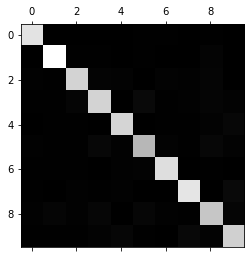

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

* The 5s look slightly darker than the other digits, which could mean that
there are fewer images of 5s in the dataset or that the classifier does not perform as well on 5s as on other
digits. In fact, you can verify that both are the case

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

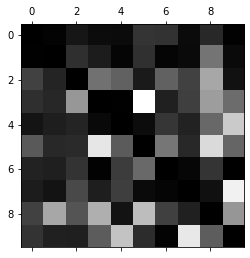

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* it seems that your efforts should be spent on improving classification of 8s and 9s, as well as
fixing the specific 3/5 confusion.

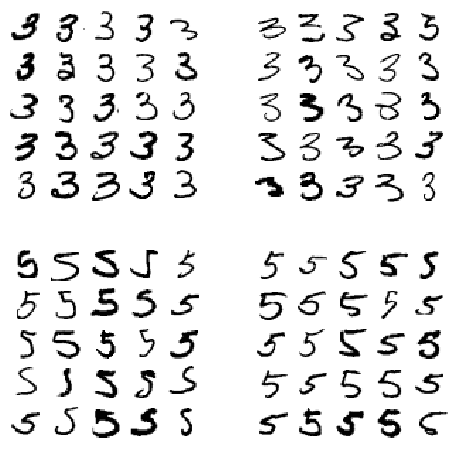

In [ ]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

# Multilabel Classification

In [ ]:
from sklearn.neighbors import KNeighborsClassifier 
# KNN supports multilabel classification, but not all classifiers do

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])

array([[False,  True]])

* The some_digit(5) is indeed not larger than 7 (False) and odd (True).

# Multioutput Classification

In [ ]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

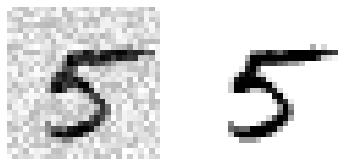

In [ ]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

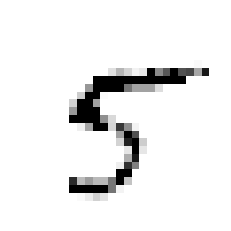

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)